<a href="https://colab.research.google.com/github/Bryan-Az/ClusteringMethod-Slate/blob/main/Audio_Embeddings_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import zipfile
import os
import librosa
import pandas as pd
import numpy as np
import shutil
import matplotlib.pyplot as plt
import keras

# Audio Clustering of Emotional Actor Speech Dataset

## Data Loading

In [2]:
def process_audio_from_zip(zip_path):
    """
    This function takes in the path to a zip file containing audio files.
    It then processes the audio data using librosa and creates and returns a dataframe.
    """
    # set extract path to name of zip
    extract_path = zip_path.split('.')[0]
    # create the directory if it doesn't exist
    if not os.path.exists(extract_path):
        print('Extracting zip file ' + zip_path.split('/')[1] + ' to ' + zip_path.split('.')[0])
        os.makedirs(extract_path)

        # extract the contents of the zip file to the directory
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_path)
    # first, simple audio features used by librosa, excluding the raw data
    # features: tempo, spectral_centroid, spectral_bandwidth, spectral_rolloff, zero_crossing_rate
    #           chroma_stft, mfcc, rmse

    # second, inherent emotion features
    # creating the feature dictionary to return later as a df
    feature_dict = {'actor': [], 'tempo': [], 'y':[], 'sr':[], 'onset_env':[], 'spectral_centroid': [], 'spectral_bandwidth':[], 'spectral_rolloff':[], 'zero_crossing_rate':[], 'chroma_stft':[],
                    'mfcc':[], 'rmse':[], 'beats':[]
    }
    # for each file in the directory ill be inserting the data into the feature dictionary
    for actor_dir in os.listdir(extract_path):
        if not actor_dir.startswith('Actor'):
            continue
        print('Processing the actor directory: ' + actor_dir)
        for wav_file in os.listdir(extract_path + '/' + actor_dir):
            if not wav_file.endswith('.wav'):
                continue
            ### Process Librosa Features ###
            # load the audio file
            y, sr = librosa.load(extract_path + '/' + actor_dir + '/' + wav_file)
            # calculate the tempo
            tempo, beats = librosa.beat.beat_track(y=y, sr=sr)
            # calculate the spectral centroid
            spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
            # calculate the spectral bandwidth
            spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
            # calculate the spectral rolloff
            spec_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
            # calculate the zero crossing rate
            zcr = librosa.feature.zero_crossing_rate(y)
            # calculate the chroma stft
            chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
            # calculate the mfcc
            mfcc = librosa.feature.mfcc(y=y, sr=sr)
            # calculate the rmse
            rmse = librosa.feature.rms(y=y)
            # calculate onset strength
            onset_env = librosa.onset.onset_strength(y=y, sr=sr)
            # add all the features to the dictionary
            # appending the features to the dictionary list with the following keys [tempo, spec_cent, spec_bw, spec_rolloff, zcr, chroma_stft, mfcc, rmse]
            feature_dict['actor'].append(actor_dir)
            feature_dict['tempo'].append(tempo)
            feature_dict['spectral_centroid'].append(spec_cent)
            feature_dict['spectral_bandwidth'].append(spec_bw)
            feature_dict['spectral_rolloff'].append(spec_rolloff)
            feature_dict['zero_crossing_rate'].append(zcr)
            feature_dict['chroma_stft'].append(chroma_stft)
            feature_dict['mfcc'].append(mfcc)
            feature_dict['rmse'].append(rmse)
            feature_dict['onset_env'].append(onset_env)
            feature_dict['y'].append(y)
            feature_dict['sr'].append(sr)
            feature_dict['beats'].append(beats)
            # deleting the root directory after processing
    print("Deleting the root directory " + extract_path)
    shutil.rmtree(extract_path)
    
    actor_audio_df = pd.DataFrame(feature_dict)
    return actor_audio_df

In [3]:
actor_speech_df = process_audio_from_zip('data_samples/ActorsSpeech_1-8.zip')

Extracting zip file ActorsSpeech_1-8.zip to data_samples/ActorsSpeech_1-8
Processing the actor directory: Actor_04
Processing the actor directory: Actor_03
Processing the actor directory: Actor_02
Processing the actor directory: Actor_05
Processing the actor directory: Actor_07
Processing the actor directory: Actor_06
Processing the actor directory: Actor_01
Processing the actor directory: Actor_08
Deleting the root directory data_samples/ActorsSpeech_1-8


## Data Selection
As the Audio clustering assignment requires us to create an image encoding of the selected audio feature to be used for training, we only need those features which are used to create a "Mel Spectogram" - a visualization that can be saved as a png/jpg and then used to train a image clustering algorithm

In [4]:
# we need to select onset_env, sr, y, beats
mel_feature_df = actor_speech_df.loc[:, ['actor', 'onset_env', 'sr', 'y', 'beats']]

In [5]:
mel_feature_df.head()

,actor,onset_env,sr,y,beats
0,Actor_04,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.023...",22050,"[9.800437e-06, 7.782373e-06, -2.2437437e-06, 9...","[14, 44, 74]"
1,Actor_04,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22050,"[-2.3260559e-07, 2.7257937e-07, -2.9780148e-07...","[28, 45, 62, 81]"
2,Actor_04,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22050,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[20, 45, 66]"
3,Actor_04,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22050,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[22, 45]"
4,Actor_04,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22050,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[46]


In [6]:
mel_feature_df.shape

(480, 5)

## Saving Spectogram Image features

In [11]:
import matplotlib.pyplot as plt

def saveplot_melspec(audio_features, source, index):
    hop_length = 512
    fig, ax = plt.subplots()
    # increase size of the plot
    fig.set_size_inches(18.5, 10.5)
    times = librosa.times_like(audio_features['onset_env'], sr=audio_features['sr'], hop_length=hop_length)
    M = librosa.feature.melspectrogram(y=audio_features['y'], sr=audio_features['sr'], hop_length=hop_length)
    ax.imshow(librosa.power_to_db(M, ref=np.max),
              aspect='auto', origin='lower', extent=[times.min(), times.max(), 0, M.shape[0]],
              cmap='magma')
    
    ax.set(title='Mel spectrogram of Actor Speech from ' + source + ', Index: ' + index)
    # save the plot
    if not os.path.exists('melplots'):
        os.makedirs('melplots')
    plt.savefig('melplots/melspectrogram_beats_' + source + '_' + index + '.png')
    # close the plot
    plt.close()


In [12]:
# apply the saveplot_specbeat function to each row of the dataframe
for index, row in mel_feature_df.iterrows():
    # use actor as the source
    source = row['actor']
    # use index as the index
    index = str(index)
    # call the function
    saveplot_melspec(row, source, index)

## Clustering the Mel spectogram Images gathered from the Audio

In [38]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np
import os
import glob
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
# we want to cluster the mel spectograms by k-means.
# First we can use an encoding/decoding M.L model on the the spectograms 
# goal: outputting a compressed version of the original spectograms. Why? For extracting important features that were learned from the spectograms.
# These features can then be clustered seperately from the encoding/decoding model using k-means
# This is a form of dimensionality reduction
# we will use a convolutional autoencoder for this task
# we will use the mel spectograms as the input and output of the autoencoder
# we will use the compressed version of the spectograms as the input to the k-means algorithm
# Step 1: Load the images from the melplots directory
image_dir = 'melplots/'
image_files = glob.glob(image_dir + '*.png')
normalized_images = []
image_size = (128, 128)  # Set the desired image size
normalized_images_index = []
for file in image_files:
    image = Image.open(file).convert('RGB')  # Convert to RGB
    resized_image = image.resize(image_size)  # Resize image
    normalized_image = np.array(resized_image) / 255.0  # Normalize
    normalized_image = normalized_image.reshape((128, 128, 3))  # Ensure correct shape
    normalized_images.append(normalized_image)
    normalized_images_index.append(file.split('_')[-1].split('.')[0])


# Step 3: Split the dataset into training and validation sets, making sure the index (normalized_images_index) is split the same way
train_images, val_images, train_index, val_index = train_test_split(normalized_images, normalized_images_index, test_size=0.2, random_state=42)


# Step 4: Define the architecture of the autoencoder model
input_shape = (128, 128, 3)  # Assuming RGB images

latent_dim = 64  # Set the dimension of the latent space

input_layer = Input(shape=input_shape)
# Encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_layer, decoded)

# Step 5: Compile the model
autoencoder.compile(optimizer='adam', loss='mse')

# Step 6: Train the model
epochs = 10  # Set the number of training epochs
batch_size = 32  # Set the batch size

history = autoencoder.fit(
    np.array(train_images),
    np.array(train_images),
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(np.array(val_images), np.array(val_images))
)

# Step 7: Evaluate the model
loss = autoencoder.evaluate(np.array(val_images), np.array(val_images))
print('Validation Loss:', loss)

# Step 8: Save the trained model
autoencoder.save('autoencoder_model.h5')

# Rest of the code remains the same

autoencoder = Model(input_layer, decoded)

# Step 5: Compile the model
autoencoder.compile(optimizer='adam', loss='mse')

# Step 6: Train the model
epochs = 10  # Set the number of training epochs
batch_size = 32  # Set the batch size

history = autoencoder.fit(
    np.array(train_images),
    np.array(train_images),
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(np.array(val_images), np.array(val_images))
)

# Step 7: Evaluate the model
loss = autoencoder.evaluate(np.array(val_images), np.array(val_images))
print('Validation Loss:', loss)

# Step 8: Save the trained model
autoencoder.save('autoencoder_model.h5')



Epoch 1/10
12/12 [==============================] - 13s 999ms/step - loss: 0.1152 - val_loss: 0.0449
Epoch 2/10
12/12 [==============================] - 12s 970ms/step - loss: 0.0301 - val_loss: 0.0187
Epoch 3/10
12/12 [==============================] - 12s 1s/step - loss: 0.0179 - val_loss: 0.0138
Epoch 4/10
12/12 [==============================] - 12s 986ms/step - loss: 0.0127 - val_loss: 0.0105
Epoch 5/10
12/12 [==============================] - 12s 1s/step - loss: 0.0095 - val_loss: 0.0082
Epoch 6/10
12/12 [==============================] - 13s 1s/step - loss: 0.0076 - val_loss: 0.0068
Epoch 7/10
12/12 [==============================] - 56s 5s/step - loss: 0.0065 - val_loss: 0.0060
Epoch 8/10
12/12 [==============================] - 20s 2s/step - loss: 0.0060 - val_loss: 0.0057
Epoch 9/10
12/12 [==============================] - 13s 1s/step - loss: 0.0056 - val_loss: 0.0053
Epoch 10/10
3/3 [==============================] - 1s 198ms/step - loss: 0.0051
Validation Loss: 0.0050908145

In [40]:
# Creating the validation df for plotting the clusters predicted by k-means
val_df = pd.DataFrame(val_index, columns=['index'])

In [43]:
# using the val_df index column to extract the metadata from the mel_feature_df
val_df['actor'] = mel_feature_df.iloc[val_df['index'].astype(int)]['actor'].values
val_df['onset_env'] = mel_feature_df.iloc[val_df['index'].astype(int)]['onset_env'].values
val_df['sr'] = mel_feature_df.iloc[val_df['index'].astype(int)]['sr'].values
val_df['y'] = mel_feature_df.iloc[val_df['index'].astype(int)]['y'].values

In [44]:
val_df.head()

,index,actor,onset_env,sr,y
0,448,Actor_08,"[0.0, 0.0, 0.0, 0.015350461, 0.0, 0.026791155,...",22050,"[-0.00013115315, -0.00021357989, -0.0001711692..."
1,88,Actor_03,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22050,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,60,Actor_03,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22050,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,395,Actor_01,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.01882863, 0.0, 0.0...",22050,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,451,Actor_08,"[0.0, 0.0, 0.0, 0.11556527, 0.048161387, 0.099...",22050,"[3.0016721e-05, 5.9004607e-05, 3.7454676e-05, ..."


In [41]:
# Step 9: Load the trained model and use it to compress the images in the validation set
autoencoder = tf.keras.models.load_model('autoencoder_model.h5')
encoded_images = autoencoder.predict(np.array(val_images))

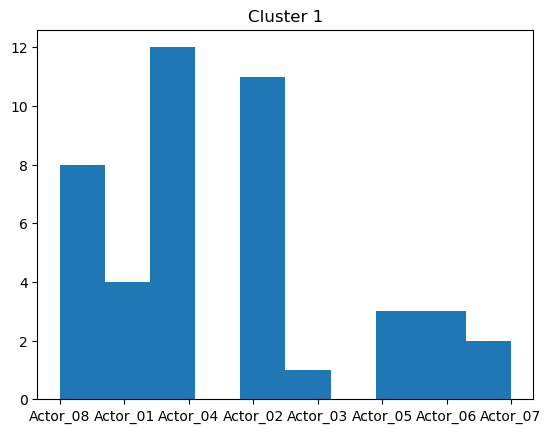

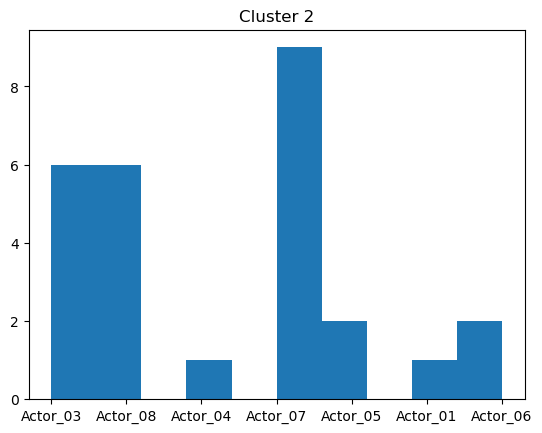

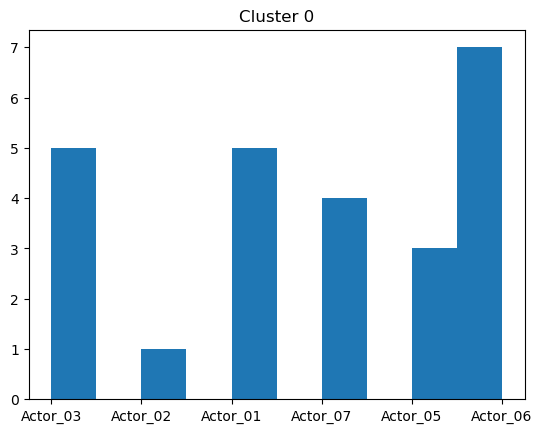

In [47]:
# use the encoded images as the input to the k-means algorithm
encoded_images = encoded_images.reshape(encoded_images.shape[0], -1)
# the encoded validation images have shape (96, 49152)
# we will use k-means to cluster the encoded images into 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42).fit(encoded_images)
# get the labels from the k-means algorithm
cluster_labels = kmeans.labels_
# add the labels to the validation dataframe
val_df['cluster_labels'] = cluster_labels
# save the dataframe
val_df.to_csv('mel_cluster_features.csv')
# plot the clusters with matplotlib
# first, we need to get the unique labels
unique_labels = val_df['cluster_labels'].unique()
# plot the clusters
for label in unique_labels:
    # get the rows with the current label
    current_rows = val_df[val_df['cluster_labels'] == label]
    # visualize the cluster distribution of the spectograms in each label using a histogram
    plt.hist(current_rows['actor'])
    plt.title('Cluster ' + str(label))
    plt.show()

    
    